In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir('../')

In [5]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts')

In [6]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import argparse 

In [7]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [104]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [131]:
# parser = argparse.ArgumentParser(description="Your script description here")

# # Add command-line arguments
# parser.add_argument('--num_objects', type=int, default=2, help='Number of objects')
# parser.add_argument('--noisy', action='store_true', help='Enable noisy')
# parser.add_argument('--weight_decay', type=float, default=0.0004, help='Weight decay value')
# parser.add_argument('--encoder_model', type=str, default='inceptionv3', help='Encoder model')
# parser.add_argument('--optimizer', type=str, default='sgd', help='Optimizer')
# parser.add_argument('--seed', type=int, default=42, help='Random seed')

# # Parse the command-line arguments
# args = parser.parse_args()

# # Now you can access the variables using args.num_objects, args.noisy, etc.
# num_objects = args.num_objects
# noisy = args.noisy
# weight_decay = args.weight_decay
# encoder_model = args.encoder_model
# optimizer = args.optimizer
# seed = args.seed

num_objects = 1
noisy=False
weight_decay = 0.0004
encoder_model='small3'
optimizer = 'sgd'
seed = 42

results_folder = "results/synthetic/objects={}_noisy={}_wd={}_model={}_optimizer={}_seed={}".format(
    num_objects,noisy,weight_decay,encoder_model,optimizer,seed
)

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [132]:
np.random.seed(seed)
torch.manual_seed(seed)

In [133]:
train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy)
val_images, val_y, val_c = unroll_data(val_loader)

In [134]:
joint_model = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

## Plot the Dataset

In [131]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image.save("{}/{}.png".format(results_folder,i+1))

## Analyze Accuracy

In [132]:
train_acc, val_acc = get_accuracy(joint_model,run_joint_model,train_loader).item(), get_accuracy(joint_model,run_joint_model,val_loader).item()

In [133]:
accuracy_by_concept_train = get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True).detach().numpy()

## Analyze Concept-Task Relationships

In [105]:
attribute_weights, y_pred, c_pred = get_attribute_class_weights(
    joint_model,run_joint_model,joint_model.sec_model.linear.weight,val_images)

## Analyze Concept-Input Relationships

### Counterfactual Images

#### Blank, Filled, and Half Images

In [134]:
no_color = torch.Tensor([0.25,0.25,0.25])
full_color = torch.Tensor([-0.25,-0.25,0.25])

In [135]:
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
full_image = full_color.clone().view(3, 1, 1).expand_as(blank_image)

half_left = no_color.view(3, 1, 1).expand_as(blank_image).clone()
half_left[:,:,:128] = full_image[:,:,:128]

half_right = no_color.clone().view(3, 1, 1).expand_as(blank_image).clone()
half_right[:,:,128:] = full_image[:,:,128:]

In [136]:
all_images = [blank_image,full_image,half_left,half_right]
all_images = torch.stack(all_images)
str_names = ["Blank","Full","Half-Left","Half-Right"]

In [137]:
y,c = run_joint_model(joint_model,all_images)
c = c.T
c = torch.nn.Sigmoid()(c).detach().numpy()
c = np.round(c,3)

### Maximal Activation

In [26]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

In [27]:
activation_values = []

for concept_num in range(num_objects*2):
    ret_image = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                       get_valid_image_function(concept_num,num_objects,epsilon=32))
    activation_values.append (
        torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[concept_num][0].detach().numpy()
    )
    
    ret_image = ret_image.detach()[0].numpy()
    im = numpy_to_pil(ret_image) 
    im.save("{}/{}.png".format(results_folder,"adversarial_{}".format(concept_num)))


In [28]:
activation_values 

[array(1., dtype=float32), array(1., dtype=float32)]

### Patch-Based

In [140]:
grid_size = 3
concept_num = 0
grid_width = 256//grid_size
combinations = list(itertools.product([0, 1], repeat=grid_size**2))
combinations_grid = [[list(combination[i:i+grid_size]) for i in range(0, grid_size**2, grid_size)] for combination in combinations]

In [141]:
def combo_to_image(combo):
    default_image = no_color.clone().view(3, 1, 1).expand((3,256,256)).clone()
    
    for i in range(grid_size):
        for j in range(grid_size):
            if combo[i][j] == 1:
                color_tensor = full_color.view(3, 1, 1).expand((3, grid_width, grid_width))
                default_image[:,i*grid_width:(i+1)*grid_width,j*grid_width:
                              (j+1)*grid_width] = color_tensor
                
                
    return default_image

In [142]:
def combination_to_string(combination):
    return ''.join(str(element) for row in combination for element in row)

In [143]:
all_images = torch.stack([combo_to_image(i) for i in combinations_grid])
y,c = run_joint_model(joint_model,all_images)
c = torch.nn.Sigmoid()(c)
c = c.T

In [144]:
combination_to_score = {}
for i,combination in enumerate(combinations_grid):
    condensed_string = combination_to_string(combination)
    combination_to_score[condensed_string] = c.detach().numpy()[i,concept_num]
    
largest_indices = np.argsort(c.detach().numpy()[:,0])[-25:]

In [145]:
max_dif = 0
max_ind = -1

for i in largest_indices:
    combo_original = combinations_grid[i]
    modified_combo = deepcopy(combo_original)
    for j in range(grid_size):
        modified_combo[j][-1] = 0
        
    score_original = combination_to_score[combination_to_string(combo_original)]
    score_modified = combination_to_score[combination_to_string(modified_combo)]

    if score_original-score_modified > max_dif:
        max_dif = score_original-score_modified
        max_ind = i

In [146]:
combo_original = combinations_grid[max_ind]
modified_combo = deepcopy(combo_original)
for j in range(grid_size):
    modified_combo[j][-1] = 0

In [147]:
im_original = numpy_to_pil(combo_to_image(combo_original).detach().numpy())
im_final = numpy_to_pil(combo_to_image(modified_combo).detach().numpy())

In [149]:
im_original.save("{}/{}.png".format(results_folder,'original_combo'))
im_final.save("{}/{}.png".format(results_folder,'modified_combo'))

### Saliency Maps

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/captum/attr/_utils/visualization.py:52: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


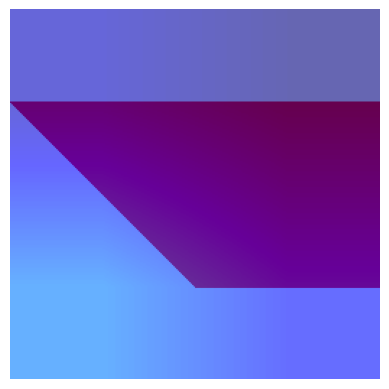

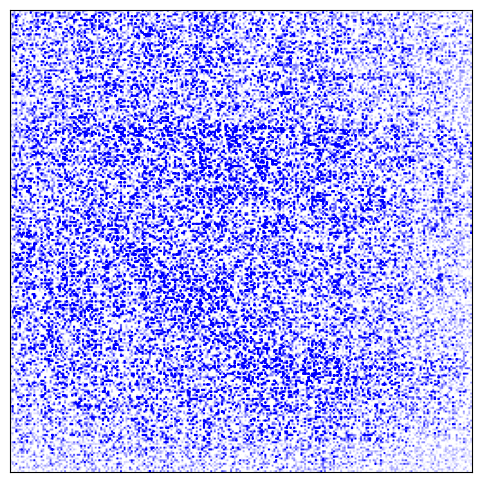

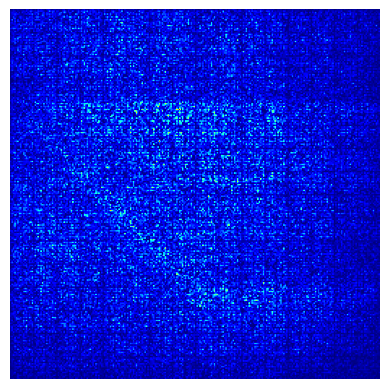

In [21]:
for method, method_name in zip(
    [plot_gradcam,plot_integrated_gradients,plot_saliency],
    ['gradcam','integrated_gradients','saliency']
):
    plt.axis('off')
    ret = method(joint_model,run_joint_model,0,val_images,0,val_pkl)

    if method_name == 'integrated_gradients':
        ret[0].savefig('{}/{}.png'.format(results_folder,method_name),bbox_inches='tight')
    else:
        plt.savefig('{}/{}.png'.format(results_folder,method_name),bbox_inches='tight')

In [155]:
final_data = {
    'train_accuracy': train_acc, 
    'val_accuracy': val_acc, 
    'concept_accuracy': accuracy_by_concept_train.tolist(), 
    'adversarial_activations': np.array(activation_values).tolist(),  
    'grid_dif': float(max_dif), 
    'num_objects': num_objects, 
    'noisy': noisy,
    'weight_decay': weight_decay,
    'encoder_model': encoder_model, 
    'optimizer': optimizer, 
    'seed': seed,
}

In [156]:
json.dump(final_data,open("{}/results.json".format(results_folder),"w"))